## Environment

In [11]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1


import os
import sys
# add the 'src' directory as one where we can import modules
root_dir = os.path.join(os.getcwd(),os.pardir,os.pardir)
src_dir = os.path.join(os.getcwd(), os.pardir,os.pardir, 'src')
if src_dir not in sys.path: sys.path.append(src_dir)


import pandas as pd
import math
import numpy as np

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import copy as cp

import seaborn as sns
sns.set()

import statsmodels.api as sm
from scipy.stats import chisquare

from sklearn.metrics import classification_report, confusion_matrix,mean_squared_error as MSE
from sklearn.metrics import precision_recall_fscore_support as report
from sklearn.preprocessing import StandardScaler

import helpers as hlp
%aimport helpers
from data.preprocessing import load_file,save_file,filter_by_season,encode
%aimport data.preprocessing

pd.options.display.max_rows = 10

from IPython.display import display

from dotenv import find_dotenv, load_dotenv
#Load env vars
load_dotenv(find_dotenv())

subfolder = os.getenv("SUBFOLDER")
PREFIX = os.getenv("PREFIX")
raw_path = os.path.join(root_dir,"data\\raw\\",subfolder)
interim_path = os.path.join(root_dir,"data\\interim\\",subfolder) 
processed_path = os.path.join(root_dir,"data\\processed\\",subfolder) 

reports_path = os.path.join(root_dir,"reports\\",subfolder)
models_path = os.path.join(root_dir,"models\\",subfolder)

row_headers=["Product"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Feature Engineering

In [16]:
! python c:/Users/rahmim00/Documents/Notebooks/Clustering/pc_clustering/src/features/build_features.py

2018-07-12 14:30:55,523 - data.preprocessing - ERROR - File b'C:\\Users\\rahmim00\\Documents\\Notebooks\\Clustering\\pc_clustering\\data\\interim\\7SEF\\7S_product_sales_raw.csv' does not exist
Traceback (most recent call last):
  File "c:/Users/rahmim00/Documents/Notebooks/Clustering/pc_clustering/src/features/build_features.py", line 292, in <module>
    main()
  File "C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\click\core.py", line 722, in __call__
    return self.main(*args, **kwargs)
  File "C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\click\core.py", line 697, in main
    rv = self.invoke(ctx)
  File "C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\click\core.py", line 895, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\click\core.py", line 535, in invoke
    ret

In [7]:
s = "Autumn"
v = 1
clustering_model = "nb_p2_clusters_%s"%(s)

#Load files
raw_df = load_file("p2_raw").set_index(row_headers)
series_df =load_file("p2_series",type_="P",version = 1).set_index(row_headers)
clean_df = load_file("p2_clean",type_="P",version = 1).set_index(row_headers)

#Filter and normalize
sclean_df = filter_by_season(clean_df,s)
z_data = StandardScaler(with_mean=True, with_std=True).fit_transform(sclean_df.T).T
zclean_df = pd.DataFrame(z_data,index=sclean_df.index,columns = sclean_df.columns) 

#clustering result
cluster_df = load_file(clustering_model,index=row_headers,type_="M",version = 1)

#cleaned features
features_df = load_file('clf_features',type_="P",index = "Product")
features_df.Ldate = features_df.Ldate.apply(lambda x:str(x))

numeric = (list(features_df.columns.to_series().groupby(features_df.dtypes).groups[np.dtype('float64')]))

features_list = list(features_df.columns) + ["Cluster"]

df = features_df.join(cluster_df,how="inner")[features_list]


print(df.shape)
clean_df.head(2)

(1046, 12)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Product,,,,,,,,,,,,,,,,
3.6E+101_2,1.0,8.0,18.0,18.0,12.0,8.0,9.0,6.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
30E000400_2,68.0,460.0,1014.0,1139.0,986.0,891.0,1027.0,1028.0,776.0,641.0,499.0,323.0,197.0,141.0,89.0,63.0


## Classification Models

In [14]:
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer,LabelEncoder
from sklearn.tree import  export_graphviz
import subprocess


def visualize_tree(tree, feature_names,class_names=None):
    
    with open(reports_path+"dt.dot", 'w') as f:
        
        export_graphviz(tree, out_file=f, feature_names=feature_names,  filled=True, rounded=True, class_names=True )

    command = ["C:\\Program Files (x86)\\Graphviz2.38\\bin\\dot.exe", "-Tpng", reports_path+"dt.dot", "-o", "dt.png"]
    
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")


features_df = df[features_list].copy()
data = features_df.copy()
data["Sales Season"] = s
print(data.shape)
display(data.head())

(1046, 12)


,Color,Size,Ldate,Age Group,Person,Pname,Ptype,Tprice,Currency,Sales Season,Nstore,Cluster
Product,,,,,,,,,,,,
3.6E+101_2,Other,Thick,36,29-38,Pregnant,One-Piece Pants,Thin,0.134078,Y,Autumn,0.001551,7
31C000963_2,Black,Sheer,40,29-38,Female,One-Piece Pants Inside,Thin,0.078212,$,Autumn,0.104218,7
31C002201_2,Grey,No Size,36,18-28,Female,One-Piece Pants Inside,Thin,0.078212,$,Autumn,0.008065,4
31C002300_2,Black,Sheer,43,29-38,Female,One-Piece Pants Inside,Thin,0.078212,$,Autumn,0.105149,7
31C002400_2,Black,Sheer,37,29-38,Female,One-Piece Pants Inside,Thin,0.106145,$,Autumn,0.106390,4


In [17]:
X = encode(data.drop(["Cluster"],axis=1),non_categorical = numeric)
feature_labels = X.columns
y = data["Cluster"]
print(X.shape)

series = clean_df.iloc[:,:3].copy()
series = series.apply(lambda x:x / x.std())

classifier = RandomForestClassifier(n_estimators=100,max_depth=12)

X.head(3)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\rahmim00\\Documents\\Notebooks\\Clustering\\pc_clustering\\models\\7SEF\\le_encoder.npy'

## Standard evaluation metrics of the algorithm

In [98]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

classifier = RandomForestClassifier(n_estimators=80,max_depth=18,min_samples_split=2, min_samples_leaf=1, criterion='gini', bootstrap=True)

# scores = cross_val_score(classifier, X, y, cv=2, scoring='f1_macro')
# print(scores,scores.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)  
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_pred_proba = classifier.predict_proba(X_test)
yt_pred = classifier.predict(X_train)

print("Train")
print(classification_report(y_train,yt_pred,labels=np.unique(y_test) )[-54*1:])
print("Test")
print(classification_report(y_test,y_pred,labels=np.unique(y_test) )[-54*1:])

Train

avg / total       0.98      0.98      0.98       836

Test

avg / total       0.40      0.40      0.39       210



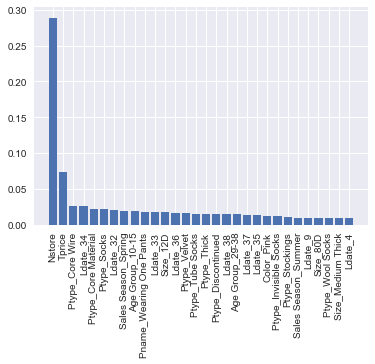

In [33]:
fi = classifier.feature_importances_
sorted_indices = np.argsort(fi)[::-1]

imp = sorted_indices[:30]

plt.bar(range(len(imp)),fi[imp])
plt.xticks(range(len(imp)), feature_labels[imp],rotation = 90)
plt.show()

### Grid Search

## RMSE to the center of the predicted cluster 
#### Joining the series with the predicted clusters of the test set

In [38]:
argsorted = np.fliplr(np.argsort(y_pred_proba, axis=1))
nguess = argsorted[:,0:4]+1

series_df = raw_df.copy()
predictions = nguess
n_pred = predictions.shape[1]
pred_df = pd.DataFrame(predictions,columns=["PC%d"%g for g in np.arange(n_pred)+1 ],index=X_test.index)

cluster_centroid = prd_cluster_df[["Cluster","Centroid"]].drop_duplicates().set_index(["Cluster"]).to_dict()["Centroid"]
centroid_cluster = {v: k for k, v in cluster_centroid.items()}


for i in np.arange(n_pred)+1:
    pred_df["PR%d"%i] = pred_df["PC%d"%i].apply(lambda x: cluster_centroid[x])
    
product_centroid = X_test.join(prd_cluster_df)[["Cluster","Centroid"]]
full_series = pred_df.join(product_centroid.join(series_df.astype(np.float64), how="inner"),how="inner")

print(full_series.shape)
display(full_series.sort_index().head().iloc[:,:])


(210, 26)


,PC1,PC2,PC3,PC4,PR1,PR2,PR3,PR4,Cluster,Centroid,...,7,8,9,10,11,12,13,14,15,16
Product,,,,,,,,,,,,,,,,,,,,,
31C003002_2,7,5,6,10,345010900_2,338020600_2,331052100_2,331032200_2,8,336013300_2,...,142.0,82.0,48.0,38.0,24.0,6.0,6.0,6.0,0.0,2.0
31C180301_2,5,10,7,8,338020600_2,331032200_2,345010900_2,336013300_2,4,31C999901_2,...,78.0,66.0,26.0,90.0,90.0,168.0,94.0,86.0,18.0,24.0
31C999904_2,12,8,1,10,335970875_2,336013300_2,331054100_2,331032200_2,9,31C999909_2,...,6362.0,10082.0,13458.0,16054.0,6762.0,9164.0,5350.0,4562.0,3002.0,1886.0
31C999905_2,8,10,1,5,336013300_2,331032200_2,331054100_2,338020600_2,1,331054100_2,...,2596.0,3480.0,4320.0,4406.0,1494.0,1978.0,1106.0,910.0,584.0,372.0
31C999906_2,1,12,9,8,331054100_2,335970875_2,31C999909_2,336013300_2,12,335970875_2,...,1080.0,1730.0,2866.0,2336.0,1862.0,1586.0,1350.0,1282.0,738.0,738.0


### Top-4 Error rate and correlation

In [47]:
p_series = full_series.copy()
N = p_series.shape[0]
notin = p_series[ (p_series.Cluster!=p_series.PC1) & (p_series.Cluster!=p_series.PC2) &(p_series.Cluster!=p_series.PC3)  &(p_series.Cluster!=p_series.PC4)].shape[0]

print("%.2f Not in Top 4 guesses"%(notin/N*100))



offset = (n_pred * 2) + 2
guess = 2

s_true = np.zeros((series_df.shape))
s_pred = np.zeros((series_df.shape))
RMSE = []
PRMSE = []
CORR = []
SP=[]
i = 0
for index,values in p_series.iterrows():
    centroid = values["PR%d"%guess]
    cluster = values["Centroid"]
    
    #Getting the series raw, centroid of actual cluster, centroid of predicted cluster
    series = (values[offset:]).astype(np.float64)#/values[offset:].std()).astype(np.float64)
    c_series = (series_df.loc[cluster]).astype(np.float64)#/series_df.loc[cluster].std()).astype(np.float64)
    predicted_series = (series_df.loc[centroid]).astype(np.float64)#/series_df.loc[centroid].std()).astype(np.float64)
    
    s_true[i] = series
    s_pred[i] = c_series
    
    n = len(series)
    rmse = math.sqrt(MSE(series,c_series)/n)
    prmse = math.sqrt(MSE(series,predicted_series)/n)
    corr = np.corrcoef(series,predicted_series)[0][1]
    
    RMSE.append(rmse)
    PRMSE.append(prmse)
    CORR.append(corr)
    i+=1
    
  
sales = p_series.values[:,offset:].astype(np.float64)
p_series["PRMSE"] = PRMSE
p_series["RMSE"] = RMSE
p_series["CORR"] = CORR
results = pd.DataFrame(index = p_series.index)

results["Mean"] = sales.mean(axis=1)
results["Std"]  = sales.std(axis=1)
results["Range"] = sales.max(axis=1) - sales.min(axis=1)
results["RMSE"] = RMSE
results["PRMSE"] = PRMSE
results["CORR"] = CORR


print("%.2f have less than 70%% correlation between predicted and actual series"%(results[results.CORR<0.7].shape[0]/N*100))


results[results.PRMSE != results.RMSE].nlargest(210,"PRMSE").head(5)

20.00 Not in Top 4 guesses
65.71 have less than 70% correlation between predicted and actual series


,Mean,Std,Range,RMSE,PRMSE,CORR
Product,,,,,,
331995291_2,19435.750,9938.958770,34252.0,4810.699832,5334.892557,0.475563
31C999904_2,4962.750,4886.429723,16000.0,1613.240925,1702.669278,-0.243498
331054000_2,3592.125,1577.126892,6584.0,458.399918,765.512706,-0.222278
326005700_2,4.000,4.242641,14.0,156.065591,753.732421,-0.006604
326005600_2,5.375,7.639331,24.0,155.786462,753.607045,-0.207227


### Predictions Plots

,PC1,PC2,PC3,PC4,PR1,PR2,PR3,PR4,Cluster,Centroid,...,7,8,9,10,11,12,13,14,15,16
Product,,,,,,,,,,,,,,,,,,,,,
331995291_2,12,9,6,1,335970875_2,31C999909_2,331052100_2,331054100_2,12,335970875_2,...,25574.0,27064.0,18920.0,24770.0,16560.0,24180.0,18446.0,21042.0,29814.0,34698.0
31C999904_2,12,8,1,10,335970875_2,336013300_2,331054100_2,331032200_2,9,31C999909_2,...,6362.0,10082.0,13458.0,16054.0,6762.0,9164.0,5350.0,4562.0,3002.0,1886.0
331054000_2,1,10,3,11,331054100_2,331032200_2,332037600_2,335030900_2,12,335970875_2,...,4618.0,4444.0,6882.0,3052.0,3350.0,2900.0,2966.0,5198.0,5794.0,3038.0
326005700_2,7,12,3,2,345010900_2,335970875_2,332037600_2,326851500_2,3,332037600_2,...,0.0,6.0,4.0,8.0,0.0,2.0,0.0,0.0,0.0,0.0
326005600_2,7,12,3,2,345010900_2,335970875_2,332037600_2,326851500_2,3,332037600_2,...,0.0,2.0,24.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0


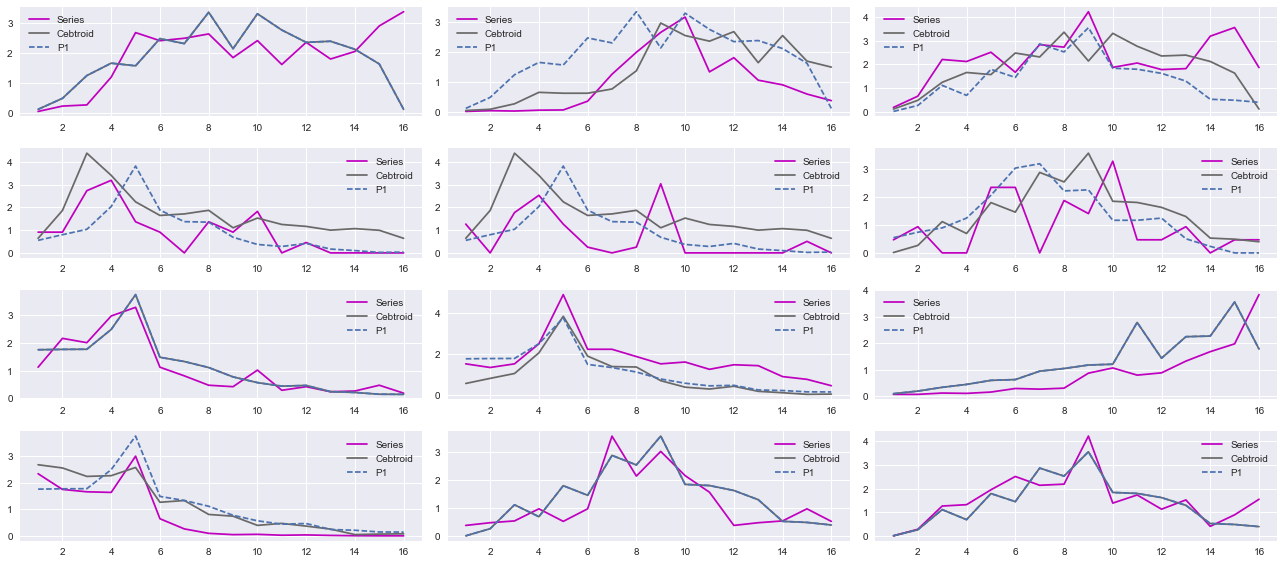

In [51]:
bad = p_series[p_series.PRMSE != p_series.RMSE].nlargest(210,"PRMSE")
good = p_series[p_series.CORR>0.8]


disp = p_series.iloc[:,:-3].loc[bad.index[:12]]
display(disp.head())




plt.figure(figsize=(18,2 * 4))
i=1;
for index,values in disp.iterrows():
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    series = values[offset:]/values[offset:].std()
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    predicted_series = series_df.loc[guess1]/series_df.loc[guess1].std()
    
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    plt.subplot(4,3,i)
    plt.plot(series,label="Series",c='m')
    plt.plot(c_series,label="Cebtroid",c='dimgrey')
    plt.plot(predicted_series,label="P1",ls='--')
#     plt.plot(p2,label="P2",ls='--')
#     plt.plot(p3,label="P3",ls='--')
    #plt.plot(p4,label="P4",ls='--')
    
    #show the centroid as well
    
    
    plt.legend(loc=0)
    
    i+=1
    

plt.tight_layout()
plt.show()

# Predict Quantities
### Load features and predictor

In [52]:
from sklearn.metrics import explained_variance_score,mean_squared_error,r2_score

features_df = prp.load_file("clf_features",type_="P",index = "Product")
features_df.Ldate = features_df.Ldate.apply(lambda x:str(x))


from sklearn.externals import joblib


features_df.head()
encoded_df = prp.encode(features_df,non_categorical = ["Tprice","Nstore"])

encoded_df.head()

,Ptype_Boat Socks,Ptype_Core Material,Ptype_Core Wire,Ptype_Core Wrap,Ptype_Core Yarn,Ptype_Disable,Ptype_Discontinued,Ptype_Invisible Socks,Ptype_Medium Thick,Ptype_Medium-Thickness,...,Person_Men,Person_Pregnant,Sales Season_Autumn,Sales Season_Spring,Sales Season_Summer,Sales Season_Winter,Currency_$,Currency_Y,Tprice,Nstore
Product,,,,,,,,,,,,,,,,,,,,,
3.6E+101_2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.134078,0.001551
30E000400_2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.106145,0.194789
30E823101_2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.106145,0.021092
30E823102_2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.106145,0.021402
30E823103_2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.106145,0.021092


count    88.000000
mean      0.550777
std       0.211552
min       0.200659
25%       0.374181
50%       0.543111
75%       0.703004
max       0.966995
Name: R2, dtype: float64

0.419047619048


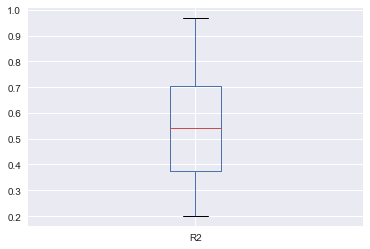

In [53]:
predictor = joblib.load(models_path+'estimator.pkl')

disp = p_series.iloc[:,:-3].loc[results.index[0:12]]
disp = p_series.iloc[:,:-3]

R2 = []
RMSE = []
BEST = []
for index,values in disp.iterrows():
    
    #Get the curves
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    #Get the std from the built predictor
    encoded = encoded_df.loc[[index]]
    prediction = predictor.predict(encoded)
    pstd = prediction
    
    #actual series
    series = values[offset:]
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    
    #curve of each prediction
    p1 = series_df.loc[guess1]/series_df.loc[guess1].std()
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    #multiply by the std
    p1 *= pstd 
    p2 *= pstd 
    p3 *= pstd
    p4 *= pstd
    c_series *= pstd
    
    rmse1 = math.sqrt(MSE(p1,series)/n)
    rmse2 = math.sqrt(MSE(p2,series)/n)
    rmse3 = math.sqrt(MSE(p3,series)/n)
    rmse4 = math.sqrt(MSE(p4,series)/n)
    
    r2_1 = r2_score(p1,series,multioutput="uniform_average")
    r2_2 = r2_score(p2,series,multioutput="uniform_average")
    r2_3 = r2_score(p3,series,multioutput="uniform_average")
    r2_4 = r2_score(p4,series,multioutput="uniform_average")
    
    r2 = [r2_1,r2_2,r2_3,r2_4]
    rmse = [rmse1,rmse2,rmse3,rmse4]
    best = np.argmin(rmse)
    
    BEST.append(best)
    R2.append(r2[best])
    RMSE.append(rmse[best])
    
disp["R2"] = R2
disp["RMSE"] = RMSE
disp["Best"] = BEST
display(disp[disp.R2>0.2].R2.describe())
disp[disp.R2>0.2].R2.plot(kind="box")
print(disp[disp.R2>0.2].R2.count()/disp.shape[0])
plt.show()

### Display First Prediction

,PC1,PC2,PC3,PC4,PR1,PR2,PR3,PR4,Cluster,Centroid,...,10,11,12,13,14,15,16,R2,RMSE,Best
Product,,,,,,,,,,,,,,,,,,,,,
335023000_2,7,11,10,5,345010900_2,335030900_2,331032200_2,338020600_2,10,331032200_2,...,74.0,88.0,52.0,36.0,22.0,2.0,18.0,0.966995,7.118335,2
345013600_2,10,1,7,9,331032200_2,331054100_2,345010900_2,31C999909_2,7,345010900_2,...,70.0,36.0,38.0,26.0,8.0,4.0,4.0,0.958607,9.015608,2
345011800_2,10,7,5,11,331032200_2,345010900_2,338020600_2,335030900_2,10,331032200_2,...,62.0,24.0,24.0,26.0,8.0,2.0,4.0,0.932440,13.223605,0
345009900_2,10,5,1,7,331032200_2,338020600_2,331054100_2,345010900_2,10,331032200_2,...,78.0,34.0,42.0,32.0,24.0,12.0,2.0,0.920564,12.523835,0
331039400_2,10,11,7,3,331032200_2,335030900_2,345010900_2,332037600_2,11,335030900_2,...,108.0,156.0,132.0,66.0,80.0,52.0,32.0,0.899948,28.261470,1


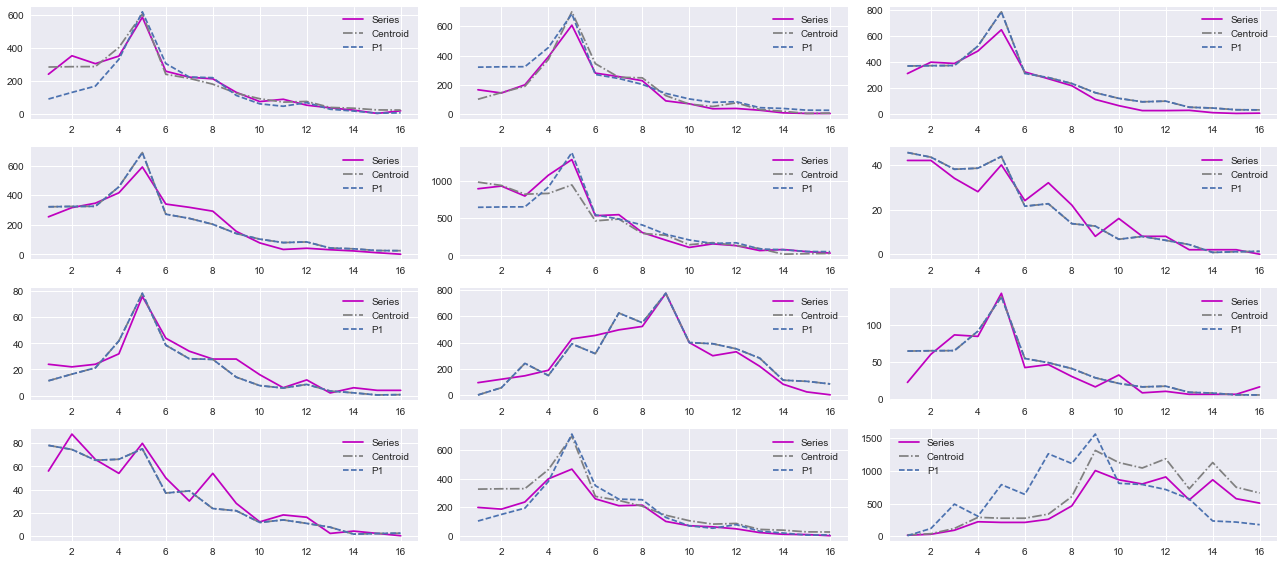

In [54]:
display_result = disp[disp.R2>0].nlargest(disp.shape[0],"R2").iloc[:12,:-3]

display(disp.loc[display_result.index].head())
plt.figure(figsize=(18,8))


i=1;
for index,values in display_result.iterrows():
    
    #Get the curves
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    #Get the std from the built predictor
    encoded = encoded_df.loc[[index]]
    prediction = predictor.predict(encoded)
    pstd = prediction
    
    #actual series
    series = values[offset:]
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    
    #curve of each prediction
    p1 = series_df.loc[guess1]/series_df.loc[guess1].std()
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    #multiply by the std
    p1 *= pstd 
    p2 *= pstd 
    p3 *= pstd
    p4 *= pstd
    c_series *= pstd
    
    plt.subplot(4,3,i)
    plt.plot(series,label="Series",c='m')
    plt.plot(c_series,label="Centroid",c='grey',ls='-.')
    
    best = disp.loc[index].Best
    p_array = pd.DataFrame([p1,p2,p3,p4],columns = series_df.columns)
    
    plt.plot(p1,label="P1",ls='--')
#     plt.plot(p2,label="P2",ls='--')
#     plt.plot(p3,label="P3",ls='--')
#     plt.plot(p4,label="P4",ls='--')



    plt.legend(loc=0)
    i+=1

plt.tight_layout()
plt.show()

### Adjusted Prediction

,PC1,PC2,PC3,PC4,PR1,PR2,PR3,PR4,Cluster,Centroid,...,10,11,12,13,14,15,16,R2,RMSE,Best
Product,,,,,,,,,,,,,,,,,,,,,
335023000_2,7,11,10,5,345010900_2,335030900_2,331032200_2,338020600_2,10,331032200_2,...,74.0,88.0,52.0,36.0,22.0,2.0,18.0,0.966995,7.118335,2
345013600_2,10,1,7,9,331032200_2,331054100_2,345010900_2,31C999909_2,7,345010900_2,...,70.0,36.0,38.0,26.0,8.0,4.0,4.0,0.958607,9.015608,2
345011800_2,10,7,5,11,331032200_2,345010900_2,338020600_2,335030900_2,10,331032200_2,...,62.0,24.0,24.0,26.0,8.0,2.0,4.0,0.932440,13.223605,0
345009900_2,10,5,1,7,331032200_2,338020600_2,331054100_2,345010900_2,10,331032200_2,...,78.0,34.0,42.0,32.0,24.0,12.0,2.0,0.920564,12.523835,0
331039400_2,10,11,7,3,331032200_2,335030900_2,345010900_2,332037600_2,11,335030900_2,...,108.0,156.0,132.0,66.0,80.0,52.0,32.0,0.899948,28.261470,1


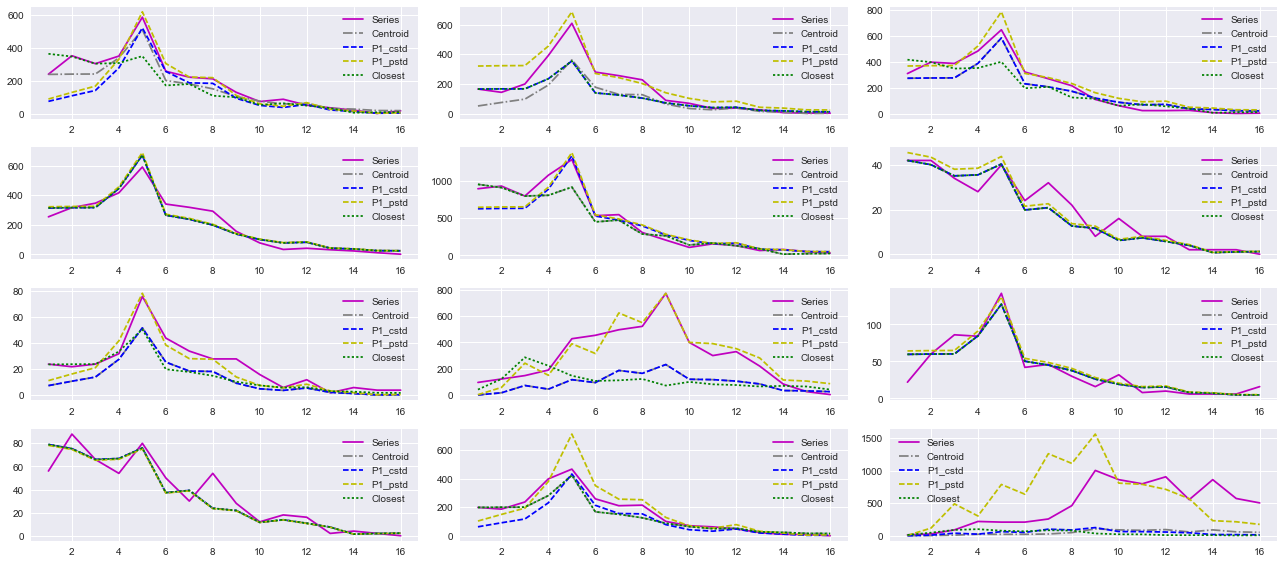

In [55]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

display_result = disp[disp.R2>0].nlargest(disp.shape[0],"R2").iloc[:12,:-3]

display(disp.loc[display_result.index].head())
plt.figure(figsize=(18,8))

n_points = 3
i=1;
for index,values in display_result.iterrows():
    
    #Get the curves
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    #Get the std from the built predictor
    encoded = encoded_df.loc[[index]]
    prediction = predictor.predict(encoded)
    pstd = prediction
    
    #actual series
    series = values[offset:]
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    
    #curve of each prediction
    p1 = series_df.loc[guess1]/series_df.loc[guess1].std()
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    
    plt.subplot(4,3,i)
    plt.plot(series,label="Series",c='m')
    
    first_points = series[:n_points]/series[:n_points].std()
    
    p_array = pd.DataFrame([p1,p2,p3,p4],columns = series_df.columns)
        
    #Adjusted
    knn = NearestNeighbors(n_neighbors=1, metric="euclidean")
    knn.fit(p_array.iloc[:,:n_points])  
    closest = knn.kneighbors([first_points], 1, return_distance=False)[0][0]
    
    cstd = (series[:n_points]/p_array.iloc[closest,:n_points]).median()
    
    #multiply by the caluclated std
    p1c = p1 * cstd 
    p1p = p1 * pstd[0]
    c_series *= cstd
    
    plt.plot(c_series,label="Centroid",c='grey',ls='-.')
    plt.plot(p1c,label="P1_cstd",ls='--',c='b')
    plt.plot(p1p,label="P1_pstd",ls='--',c='y')
    plt.plot(p_array.iloc[closest]*cstd,label="Closest",c='g',ls=':')

    plt.legend(loc=0)
    i+=1

plt.tight_layout()
plt.show()